# HW 1: Implementing Transition Systems in Python

In this exercise, we will implement the formal concept of a transition system as we defined in class using Python classes. We'll translate the mathematical definition $(S,\ Act,\ \rightarrow,\ I,\ AP,\ L)$ into code.


In [43]:
import sys
import otter

# try:
#     import otter
# except ImportError:
#     %pip install otter-grader
#     import otter

grader = otter.Notebook("HW1.ipynb")

## Challenge 1: Implementing the `TransitionSystem` class

Recall the formal definition of a transition system:

A **transition system** TS is a tuple $(S,\ Act,\ \rightarrow,\ I,\ AP,\ L)$ where:

- $S$ is a set of states
- $Act$ is a set of actions
- ${\rightarrow} \subseteq S \times Act \times S$ is a transition relation
- $I \subseteq S$ is a set of initial states
- $AP$ is a set of atomic propositions
- $L: S \rightarrow 2^{AP}$ is a labeling function

### Notation

- For $(s,\alpha,s') \in {\rightarrow}$, we write $s \xrightarrow{\alpha} s'$
- The transition system is called **finite** if $S$, $Act$, and $AP$ are finite sets
- For each state $s \in S$, $L(s)$ represents the set of atomic propositions that hold in state $s$

### Example

Let TS be a transition system modeling a simple vending machine:

- $S = \{\mathsf{ready}, \mathsf{wait}, \mathsf{done}\}$
- $Act = \{\mathsf{coin}, \mathsf{coffee}, \mathsf{tea}\}$
- $I = \{\mathsf{ready}\}$
- $AP = \{\mathsf{has\_drink}, \mathsf{paid}\}$
- Labeling function $L$:
  - $L(\mathsf{ready}) = \emptyset$
  - $L(\mathsf{wait}) = \{\mathsf{paid}\}$
  - $L(\mathsf{done}) = \{\mathsf{has\_drink}, \mathsf{paid}\}$
- Transitions:
  - $\mathsf{ready} \xrightarrow{\mathsf{coin}} \mathsf{wait}$
  - $\mathsf{wait} \xrightarrow{\mathsf{coffee}} \mathsf{done}$
  - $\mathsf{wait} \xrightarrow{\mathsf{tea}} \mathsf{done}$

## Definition: Direct Predecessors and Successors

Let $TS =(S, Act, \to, I, AP, L)$ be a transition system.

For $s \in S$ and $\alpha \in Act$, the set of direct *$\alpha$-successors* of $s$ is defined as:

$Post(s, \alpha) = \{ s' \in S \mid s \xrightarrow{\alpha} s' \}$,
$Post(s) = \bigcup_{\alpha \in Act} Post(s, \alpha)$

The set of *$\alpha$-predecessors* of $s$ is defined by:

$Pre(s, \alpha) = \{ s' \in S \mid s' \xrightarrow{\alpha} s \}$,
$Pre(s) = \bigcup_{\alpha \in Act} Pre(s, \alpha)$

For $C \subseteq S$ and $\alpha \in Act$, the set of direct *$\alpha$-successors* of $C$ is defined as:

$Post(C, \alpha) = \bigcup_{s \in C} Post(s, \alpha)$,
$Post(C) = \bigcup_{s \in C} Post(s)$

For $C \subseteq S$ and $\alpha \in Act$, the set of direct *$\alpha$-predecessors* of $C$ is defined as:

$Pre(C, \alpha) = \bigcup_{s \in C} Pre(s, \alpha)$,
$Pre(C) = \bigcup_{s \in C} Pre(s)$

## **Definition: Reachable States**

Let $ TS = (S, Act, \to, I, AP, L) $ be a transition system.

A state $ s \in S $ is called **reachable** if there exists a finite sequence of transitions leading from an initial state to $ s $.

The set of **reachable states** is defined as:

$Reach(TS) = \bigcup_{n \geq 0} Post^n(I)$

where:
- $ Post^0(I) = I $, meaning the initial states are trivially reachable.
- $ Post^{n+1}(I) = Post(Post^n(I)) $, meaning a state is reachable if there exists a sequence of transitions from an initial state.

### **Alternative Characterization**
The set of reachable states can be computed iteratively:
1. Start with the set of **initial states** $ I $.
2. Expand the set by adding **all direct successors** until no new states are added.
3. Formally, the **iterative expansion** is defined as:

   $S_0 = I$

   $S_{n+1} = S_n \cup Post(S_n)$

   where $ S_n $ is the set of states reachable within $ n $ transitions.

### **Properties**
- **Every initial state is reachable**: $ I \subseteq Reach(TS) $.
- **Every transition only connects reachable states**: If $ s \xrightarrow{\alpha} s' $, then $ s' $ is reachable whenever $ s $ is.
- **If a state is not in $ Reach(TS) $, it can never be visited** from any initial state.

### **Intuition**
The **reachable states** represent **all the states that can actually be encountered** when executing the transition system, starting from any initial state.


## **Definition: Action-Deterministic and Label-Deterministic Transition Systems**

Let $TS = (S, Act, \to, I, AP, L)$ be a transition system.

### **Action-Deterministic Transition System**
A transition system is called **action-deterministic** if:
1. It has at most **one initial state**, i.e., $|I| \leq 1$.
2. For every state $s \in S$ and every action $\alpha \in Act$, there is at most **one successor state** $ s' $ such that:

   $|Post(s, \alpha)| \leq 1$

   This means that whenever an action $ \alpha $ is taken from state $ s $, the system **must transition to at most one unique state**.

### **Label-Deterministic Transition System**
A transition system is called **label-deterministic** if:
1. It has at most **one initial state**, i.e., $ |I| \leq 1 $.
2. For every state $ s \in S $, the set of its direct successors must have **distinct atomic proposition labels**:

    $|Post(s)| = |\{ L(s') \mid s' \in Post(s) \}|$

   This means that no two successors of the same state $ s $ should have the **same labeling function output**.

In other words:
- **Action-determinism** ensures that the system **always knows** where it will transition based on an action.
- **Label-determinism** ensures that the labels of successor states are always **unique**, preventing ambiguity in atomic propositions.


Your task is to implement the `TransitionSystem` class in Python. The class should have the following methods:

In [44]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import Set, Dict, Tuple, Union, Optional

State = Union[str, Tuple]  # A state can be a string or a tuple (location, environment)
Action = str  # Actions are represented as strings
Transition = Tuple[State, Action, State]  # (source_state, action, target_state)
LabelingMap = Dict[State, Set[str]]  # Maps states to atomic propositions


class TransitionSystem:
    """
    A Transition System (TS) representation.

    Attributes:
        S (Set[State]): The set of all states (strings or tuples).
        Act (Set[Action]): The set of all possible actions.
        Transitions (Set[Transition]): The set of transitions, each represented as (state_origin, action, state_target).
        I (Set[State]): The set of initial states.
        AP (Set[str]): The set of atomic propositions.
        _L (LabelingMap): A dictionary mapping states to their respective atomic propositions.
    """

    def __init__(
        self,
        states: Optional[Set[State]] = None,
        actions: Optional[Set[Action]] = None,
        transitions: Optional[Set[Transition]] = None,
        initial_states: Optional[Set[State]] = None,
        atomic_props: Optional[Set[str]] = None,
        labeling_map: Optional[LabelingMap] = None,
    ) -> None:
        """
        Initializes the Transition System.

        :param states: A set of states (each a string or a tuple). Defaults to an empty set.
        :param actions: A set of actions. Defaults to an empty set.
        :param transitions: A set of transitions, each as (state_origin, action, state_target). Defaults to an empty set.
        :param initial_states: A set of initial states. Defaults to an empty set.
        :param atomic_props: A set of atomic propositions. Defaults to an empty set.
        :param labeling_map: A dictionary mapping states to sets of atomic propositions. Defaults to an empty dictionary.
        """
        self.S: Set[State] = set(states) if states is not None else set()
        self.Act: Set[Action] = set(actions) if actions is not None else set()
        self.Transitions: Set[Transition] = set(transitions) if transitions is not None else set()
        self.I: Set[State] = set(initial_states) if initial_states is not None else set()
        self.AP: Set[str] = set(atomic_props) if atomic_props is not None else set()
        self._L: LabelingMap = dict(labeling_map) if labeling_map is not None else {}

    def add_state(self, *states: State) -> "TransitionSystem":
        """
        Adds one or more states to the transition system.

        :param states: One or more states (strings or tuples) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """
        self.S.update(states)
        return self

    def add_action(self, *actions: Action) -> "TransitionSystem":
        """
        Adds one or more actions to the transition system.

        :param actions: One or more actions (strings) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """
        self.Act.update(actions)
        return self

    def add_transition(self, *transitions: Transition) -> "TransitionSystem":
        """
        Adds one or more transitions to the transition system.
        Ensures that all involved states and actions exist before adding the transitions.

        Each transition must be provided as a tuple of the form `(state_from, action, state_to)`, where:
        - `state_from` is the source state.
        - `action` is the action performed.
        - `state_to` is the resulting state.

        :param transitions: One or more transitions, each as a tuple `(state_from, action, state_to)`.
        :raises ValueError:
            - If a transition is not a tuple of length 3.
            - If `state_from` or `state_to` does not exist in `self.S`.
            - If `action` is not in `self.Act`.
        :return: The `TransitionSystem` instance (for method chaining).
        """
        for transition in transitions:
            if len(transition) != 3:
                raise ValueError("Each transition must be a tuple of length 3.")
            state_from, action, state_to = transition
            if state_from not in self.S:
                raise ValueError(f"State {state_from} is not in the transition system.")
            if state_to not in self.S:
                raise ValueError(f"State {state_to} is not in the transition system.")
            if action not in self.Act:
                raise ValueError(f"Action {action} is not in the transition system.")
            self.Transitions.add(transition)
        return self

    def add_initial_state(self, *states: State) -> "TransitionSystem":
        """
        Adds one or more states to the set of initial states.

        :param states: One or more states to be marked as initial.
        :raises ValueError: If any state does not exist in the system.
        :return: The TransitionSystem instance (for method chaining).
        """
        for state in states:
            if state not in self.S:
                raise ValueError(f"Initial state {state} must be in the transition system.")
        self.I.update(states)
        return self

    def add_atomic_proposition(self, *props: str) -> "TransitionSystem":
        """
        Adds one or more atomic propositions to the transition system.

        :param props: One or more atomic propositions (strings) to be added.
        :return: The TransitionSystem instance (for method chaining).
        """
        self.AP.update(props)
        return self

    def add_label(self, state: State, *labels: str) -> "TransitionSystem":
        """
        Adds one or more atomic propositions to a given state.

        :param state: The state to label.
        :param labels: One or more atomic propositions to be assigned to the state.
        :raises ValueError: If the state is not in the system or if any label is not a valid atomic proposition.
        :return: The TransitionSystem instance (for method chaining).
        """
        if state not in self.S:
            raise ValueError(f"Cannot set labels for {state}. State is not in the transition system.")
        if state not in self._L:
            self._L[state] = set()
        invalid = set(labels) - self.AP
        if invalid:
            raise ValueError(
                f"Cannot assign labels {invalid}. They are not in the set of atomic propositions (AP)."
            )
        self._L[state].update(labels)
        return self

    def L(self, state: State) -> Set[str]:
        """
        Retrieves the set of atomic propositions that hold in a given state.

        :param state: The state whose atomic propositions are being retrieved.
        :raises ValueError: If the state is not in the transition system.
        :return: A set of atomic propositions associated with the given state.
        """
        if state not in self.S:
            raise ValueError(f"State {state} is not in the transition system.")
        return self._L.get(state, set())

    def pre(self, S: Union[State, Set[State]], action: Optional[Action] = None) -> Set[State]:
        """
        Computes the set of predecessor states from which a given state or set of states can be reached.

        :param S: A single state (string/tuple) or a collection of states.
        :param action: (Optional) If provided, filters only the transitions that use this action.
        :return: A set of predecessor states.
        """
        if isinstance(S, str):
            S = {S}
        predecessors = set()
        for state_from, action_taken, state_to in self.Transitions:
            if action is None or action_taken == action:
                if state_to in S:
                    predecessors.add(state_from)
        return predecessors

    def post(self, S: Union[State, Set[State]], action: Optional[Action] = None) -> Set[State]:
        """
        Computes the set of successor states reachable from a given state or a collection of states.

        :param S: A single state or a collection of states.
        :param action: (Optional) Filters transitions by this action.
        :return: A set of successor states.
        """
        if isinstance(S, str):
            S = {S}
        successors = set()
        for state_from, action_taken, state_to in self.Transitions:
            if action is None or action_taken == action:
                if state_from in S:
                    successors.add(state_to)
        return successors

    def reach(self) -> Set[State]:
        """
        Computes the set of all reachable states from the initial states.

        :return: A set of reachable states.
        """
        # like BFS 
        reachable = set(self.I)
        new_states = set(self.I)
        while new_states:
            new_states = self.post(new_states)
            reachable.update(new_states)
        return reachable

    def is_action_deterministic(self) -> bool:
        """
        Checks whether the transition system is action-deterministic.

        A transition system is action-deterministic if:
        - It has at most one initial state.
        - For each state and action, there is at most one successor state.

        :return: True if the transition system is action-deterministic, False otherwise.
        """
        if len(self.I) > 1:
            return False
        for state in self.S:
            for action in self.Act:
                if len(self.post(state, action)) > 1:
                    return False
        return True

    def is_label_deterministic(self) -> bool:
        """
        Checks whether the transition system is label-deterministic.

        A transition system is label-deterministic if:
        - It has at most one initial state.
        - For each state, the number of reachable successor states is equal to the number of unique label sets
          of these successor states.

        :return: True if the transition system is label-deterministic, False otherwise.
        """
        if len(self.I) > 1:
            return False
        for state in self.S:
            labels = {frozenset(self.L(s)) for s in self.post(state)}
            if len(labels) != len(self.post(state)):
                return False
        return True

    def __repr__(self) -> str:
        """
        Returns a string representation of the Transition System.

        :return: A formatted string representation of the TS.
        """
        return (
            f"TransitionSystem(\n"
            f"  States: {self.S}\n"
            f"  Actions: {self.Act}\n"
            f"  Transitions: {len(self.Transitions)}\n"
            f"  Initial States: {self.I}\n"
            f"  Atomic Propositions: {self.AP}\n"
            f"  Labels: {self._L}\n"
            f")"
        )


    def plot(self, title: str = "Transition System", figsize: Tuple[int, int] = (10, 6)) -> None:
        """
        Plots the Transition System as a directed graph.

        :param title: Title of the plot.
        :param figsize: Figure size for the plot.
        """
        G = nx.DiGraph()

        # Add nodes (states)
        for state in self.S:
            label = f"{state}\n{' '.join(self.L(state))}" if self.L(state) else str(state)
            print(label)
            G.add_node(state, label=label, color="blue" if state in self.I else "yellow")

        # Add edges (transitions)
        for state_from, action, state_to in self.Transitions:
            G.add_edge(state_from, state_to, label=action)

        plt.figure(figsize=figsize)
        pos = nx.spring_layout(G)  # Positioning algorithm for layout

        # Draw nodes
        node_colors = [G.nodes[n]["color"] for n in G.nodes]
        nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, "label"), node_color=node_colors, edgecolors="black", node_size=2000, font_size=10)

        # Draw edge labels (actions)
        edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

        plt.title(title)
        # plt.show()


### Pre/Post Example Usage:

In [45]:
states = {'s1', 's2', 's3'}
actions = {'a', 'b'}
transitions = {('s1', 'a', 's2'), ('s2', 'b', 's3'), ('s3', 'a', 's1')}
initial_states = {'s1'}
atomic_props = {'p', 'q'}
labeling = {'s1': {'p'}, 's2': {'q'}, 's3': {'p', 'q'}}

ts = TransitionSystem()

for s in states:
    ts.add_state(s)

for a in actions:
    ts.add_action(a)

for t in transitions:
    ts.add_transition(t)

for s in initial_states:
    ts.add_initial_state(s)

for ap in atomic_props:
    ts.add_atomic_proposition(ap)

for s, aps in labeling.items():
    ts.add_label(s, *aps)

print(ts.post('s1', 'a'))  # Output: {'s2'}
print(ts.post('s1'))  # Output: {'s2'}
print(ts.pre('s2', 'a'))  # Output: {'s1'}
print(ts.pre('s2'))  # Output: {'s1'}
print(ts.post({'s1', 's2'}, 'a'))  # Output: {'s2'}
print(ts.post({'s1', 's2'}))  # Output: {'s2', 's3'}
print(ts.pre({'s2', 's3'}, 'a'))  # Output: {'s1'}
print(ts.pre({'s2', 's3'}))  # Output: {'s1', 's2'}

{'s2'}
{'s2'}
{'s1'}
{'s1'}
{'s2'}
{'s2', 's3'}
{'s1'}
{'s2', 's1'}


In [46]:
grader.check("q1")

q1 results: All test cases passed!

Here's a classic riddle that wil will solve using state space exploration of a transition stystem in Python:

---

**The Farmer, Wolf, Goat, and Cabbage Puzzle**

A farmer needs to cross a river with a wolf, a goat, and a cabbage. His boat can only carry himself plus one item. However, if he leaves the wolf alone with the goat, the wolf will eat the goat, and if he leaves the goat alone with the cabbage, the goat will eat the cabbage. The wolf and the cabbage can be left together safely. How can the farmer get all three safely across the river?*

---

**How It Translates to a State Space Problem:**

1. **States:**
   Each state can be represented as a tuple showing the positions (left or right bank) of the farmer, wolf, goat, and cabbage. For example, `('L', 'L', 'L', 'L')` might represent that all four are on the left bank.

2. **Transitions:**
   Moves consist of the farmer taking one item with him (or going alone) to the opposite bank, ensuring that the move doesn't violate the puzzle's constraints (i.e., leaving the wolf with the goat or the goat with the cabbage unsupervised).

3. **Goal:**
   Reach the state `('R', 'R', 'R', 'R')` where everyone is safely on the right bank.

4. **Search Method:**
   You can implement a breadth-first search (BFS) or depth-first search (DFS) in Python to explore the state space until you find a valid sequence of moves from the initial state to the goal state.

#### **Task 1**
Implement the function `create_fwgc_transition_system()` that generates a **transition system** representing all possible valid moves in the problem.

Your implementation should:
1. Define all **possible states** using `"L"` (left bank) and `"R"` (right bank) for each entity: **Farmer (F), Wolf (W), Goat (G), and Cabbage (C)**.
2. Define all **valid actions**, which include:
   - `"alone"` → The farmer crosses alone.
   - `"with_wolf"` → The farmer crosses with the wolf.
   - `"with_goat"` → The farmer crosses with the goat.
   - `"with_cabbage"` → The farmer crosses with the cabbage.
3. Add **atomic propositions** to classify states:
   - `"unsafe"` → A state where the goat gets eaten.
   - `"solution"` → A state where all entities reach `"RRRR"`.
4. Define **transitions**:
   - Farmer moves **alone** or **with one other entity**, updating the state accordingly.
   - Invalid transitions (that lead to unsafe states) should be excluded.

---
#### **Expected Output**
When `create_fwgc_transition_system()` is called, it should return an instance of `TransitionSystem` where:
- All valid states and transitions are created.
- The `"LLLL"` state is the initial state.
- The `"RRRR"` state is marked as `"solution"`.
- `"unsafe"` states are properly labeled.

In [52]:
def create_fwgc_transition_system():
    from itertools import product

    def is_safe(state) -> bool:
        """Returns True if the state is safe, False if the goat gets eaten."""
        f, w, g, c = state
        # If farmer is not with goat, and either wolf or cabbage is with goat — unsafe
        if f != g:
            if w == g or c == g:
                return False
        return True

    def move(state, action) -> str | None:
        """Return the resulting state after taking an action, or None if invalid."""
        f, w, g, c = state
        side = {'L': 'R', 'R': 'L'}
        new_state = list(state)

        # Move farmer
        new_state[0] = side[f]

        if action == "with_wolf" and f == w:
            new_state[1] = side[w]
        elif action == "with_goat" and f == g:
            new_state[2] = side[g]
        elif action == "with_cabbage" and f == c:
            new_state[3] = side[c]
        elif action != "alone":
            return None  # Invalid move if entity not with farmer

        return ''.join(new_state)
    
    # Setup
    ts = TransitionSystem()

    # Add states LLLL", "LLLR", ..., "RRRR" (farmer, wolf, goat, cabbage)
    all_states = [''.join(state) for state in product(['L', 'R'], repeat=4)]
    for state in all_states:
        ts.add_state(state)

    # Add the actions "alone", "with_wolf", "with_goat", "with_cabbage"
    actions = ["alone", "with_wolf", "with_goat", "with_cabbage"]
    ts.add_action(*actions)

    # Add the atomic propositions "unsafe" and "solution"
    ts.add_atomic_proposition("unsafe", "solution")

    # Add transitions and labels
    for state in all_states:
        if not is_safe(state):
            ts.add_label(state, "unsafe")
            continue
        if state == ("RRRR"):
            ts.add_label(state, "solution")
        for action in actions:
            new_state = move(state, action)
            if new_state and new_state in ts.S and is_safe(new_state):
                ts.add_transition((state, action, new_state))

    # Add initial state
    ts.add_initial_state("LLLL")
    return ts


...

Ellipsis

LRRR
unsafe
RLLL
unsafe
RLLR
unsafe
LLRL
RLRR
LLRR
unsafe
LLLR
RRLL
unsafe
LLLL
LRLL
RRLR
RRRR
solution
RLRL
LRRL
unsafe
LRLR
RRRL


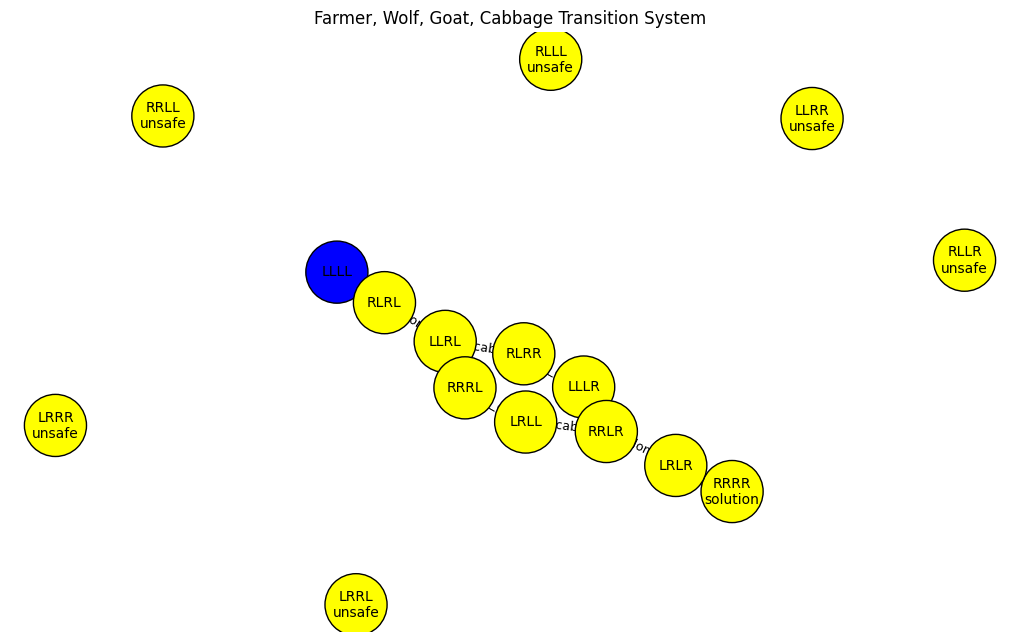

In [54]:
grader.check("q2.1")

ts = create_fwgc_transition_system()
ts.plot("Farmer, Wolf, Goat, Cabbage Transition System")

---
#### **Task 2**

After constructing the transition system for the **Farmer-Wolf-Goat-Cabbage (FWGC) problem**, the next task is to find the shortest valid sequence of moves that leads from the **initial state** (`"LLLL"`) to the **solution state** (`"RRRR"`).

Implement the function:


In [49]:
from typing import List
from collections import deque

def find_minimal_solution(ts: TransitionSystem) -> List[str]:
    # Start from the only initial state
    if len(ts.I) != 1:
        raise ValueError("Transition system must have exactly one initial state.")
    
    initial_state = next(iter(ts.I))
    visited = set()
    queue = deque([(initial_state, [])])  # (current_state, path_of_actions)

    while queue:
        state, path = queue.popleft()
        
        if state in visited:
            continue
        visited.add(state)

        # Check if it's a solution state
        if "solution" in ts.L(state):
            return path

        # Explore all transitions from this state
        for (from_state, action, to_state) in ts.Transitions:
            if from_state == state and "unsafe" not in ts.L(to_state):
                queue.append((to_state, path + [action]))

    # If no solution is found
    raise ValueError("No solution found in the transition system.")

which takes a **TransitionSystem** object and returns the **shortest sequence of actions** leading to the solution.

Your implementation should:
1. **Use BFS**: Since BFS explores all shortest paths first, it guarantees finding the minimal solution.
2. **Track visited states**: Ensure states are not revisited unnecessarily.
3. **Store the path**: Maintain the sequence of actions taken to reach each state.
4. **Stop at the solution**: If a state labeled `"solution"` is found, return the corresponding action sequence.

---
#### **Proposed structure for your function**
- Use a **queue** initialized with the starting state `"LLLL"` and an empty action path.
- Iteratively expand each state:
  - If the state has the `"solution"` label, return the path.
  - If it hasn’t been visited, mark it as visited.
  - Add all valid transitions to the queue, extending the path with the corresponding action.
- If no solution is found, raise an error.

---
#### **Example Execution**
```python
ts = create_fwgc_transition_system()
solution = find_minimal_solution(ts)
print(solution)
```
**Expected Output (one possible minimal path)**:
```python
["with_goat", "alone", "with_wolf", "with_goat", "with_cabbage", "alone", "with_goat"]
```
(The order might vary depending on transition order in the `TransitionSystem`.)

In [50]:
grader.check("q2.2")

q2.2 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [41]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)